In [12]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Reshape, Conv2DTranspose, MaxPooling2D, UpSampling2D, LeakyReLU
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

import os

import warnings
warnings.filterwarnings('ignore')
from packaging.version import parse as parse_version
assert parse_version(tf.__version__) < parse_version("2.5.1"), \
    f"Please install TensorFlow version 2.3.1 or older. Your current version is {tf.__version__}."

## Loading MNIST

In [4]:
(ds_train, ds_test_), ds_info = tfds.load('mnist', 
                              split=['train', 'test'], 
                              shuffle_files=True,
                              as_supervised=True,
                              with_info=True)


batch_size = 256
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = image/255.
    return image, image


ds_train = ds_train.map(preprocess)
ds_train = ds_train.cache() # put dataset into memory
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)

ds_test = ds_test_.map(preprocess).batch(batch_size).cache().prefetch(batch_size)

In [5]:
# return label for testing
def preprocess_with_label(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.math.round(image/255.)
    return image, label

ds_test_label = ds_test_.map(preprocess_with_label).batch(1000)

## Building Autoencoder

`z_dim` - size of the latent variable which is a 1D vector. The size of `z_dim` should be smaller than the input dimension. It is a hyperparameter. We will start with 10, which will give us a compression rate of 28*28/10 = 78.4 (i.e. each 28x28 pixels image will be represented by a 1D vector)

In [24]:
def Encoder(z_dim):
    inputs = layers.Input(shape = [28, 28, 1])
    
    x = inputs
    x = Conv2D(filters=8, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
    x = Conv2D(filters=8, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(x)
    x = Conv2D(filters=8, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
    x = Conv2D(filters=8, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(x)
    x = Flatten()(x)
    out = Dense(z_dim)(x)
    
    return Model(inputs=inputs, outputs=out, name='encoder')

def Decoder(z_dim):
    inputs = layers.Input(shape=[z_dim])
    
    x = inputs
    x = Dense(7*7*64, activation='relu')(x)
    x = Reshape((7, 7, 64))(x)
    
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(x)
    x = UpSampling2D((2,2))(x)
    
    x = Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(x)
    x = UpSampling2D((2,2))(x)
    
    out = Conv2D(filters=1, kernel_size=(3,3), strides=1, padding='same', activation='sigmoid')(x)
    
    return Model(inputs=inputs, outputs=out, name='decoder')

class Autoencoder:
    def __init__(self, z_dim):
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        
        model_input = self.encoder.input
        self.encoder.summary()
        model_output = self.decoder(self.encoder.output)
        self.decoder.summary()
        self.model = Model(model_input, model_output)

In [18]:
# size calculations
def calc_convolution_shape(W, kernel_size, padding, stride):
#     Number of filters K,
#     their spatial extent F,
#     the stride S,
#     the amount of zero padding  P
#     W2=(W1−F+2P)/S+1
    return round((W - kernel_size + 2*padding)/stride + 1)

In [25]:
autoencoder = Autoencoder(z_dim=10)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 14, 14, 8)         80        
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
flatten_6 (Flatten)          (None, 392)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                3930

In [10]:
model_path = "./models/autoencoder.h5"
os.makedirs("./models", exist_ok=True)

checkpoint = ModelCheckpoint(model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="auto", save_weights_only=False)

early = EarlyStopping(monitor="val_loss", mode="auto", patience=5)

callbacks_list = [checkpoint, early]

autoencoder.model.compile(loss="mse", optimizer=tf.keras.optimizers.RMSprop(learning_rate=3e-4))
autoencoder.model.fit(ds_train, validation_data=ds_test, epochs=100, callbacks=callbacks_list)

Epoch 1/100
235/235 [==============================] - 53s 218ms/step - loss: 0.0644 - val_loss: 0.0415

Epoch 00001: val_loss improved from inf to 0.04148, saving model to ./models\autoencoder.h5
Epoch 2/100
235/235 [==============================] - 52s 220ms/step - loss: 0.0360 - val_loss: 0.0314

Epoch 00002: val_loss improved from 0.04148 to 0.03143, saving model to ./models\autoencoder.h5
Epoch 3/100
235/235 [==============================] - 55s 232ms/step - loss: 0.0290 - val_loss: 0.0259

Epoch 00003: val_loss improved from 0.03143 to 0.02588, saving model to ./models\autoencoder.h5
Epoch 4/100
235/235 [==============================] - 54s 228ms/step - loss: 0.0258 - val_loss: 0.0251

Epoch 00004: val_loss improved from 0.02588 to 0.02514, saving model to ./models\autoencoder.h5
Epoch 5/100
235/235 [==============================] - 54s 230ms/step - loss: 0.0239 - val_loss: 0.0223

Epoch 00005: val_loss improved from 0.02514 to 0.02232, saving model to ./models\autoencoder.h5

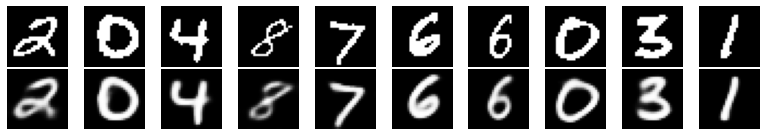

In [13]:
images, labels = next(iter(ds_test_label))
autoencoder.model = load_model(model_path)
outputs = autoencoder.model.predict(images)

grid_col = 10
grid_row = 2

f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.1, grid_row))

i = 0
for row in range(0, grid_row, 2):
    for col in range(grid_col):
        axarr[row, col].imshow(images[i,:,:,0], cmap='gray')
        axarr[row, col].axis('off')
        axarr[row+1, col].imshow(outputs[i,:,:,0], cmap='gray')
        axarr[row+1, col].axis('off')
        i += 1
f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)        
plt.show()

## Set z_dim = 2 and to look at the latent variables

In [14]:
autoencoder_2 = Autoencoder(z_dim=2)

early = EarlyStopping(monitor= "val_loss", mode= "auto", patience = 5)
callbacks_list = [early]

autoencoder_2.model.compile(loss = "mse",optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3))
autoencoder_2.model.fit(ds_train, validation_data=ds_test, epochs = 50, callbacks = callbacks_list)

Epoch 1/50
235/235 [==============================] - 50s 208ms/step - loss: 0.0651 - val_loss: 0.0544
Epoch 2/50
235/235 [==============================] - 50s 212ms/step - loss: 0.0524 - val_loss: 0.0511
Epoch 3/50
235/235 [==============================] - 51s 215ms/step - loss: 0.0495 - val_loss: 0.0487
Epoch 4/50
235/235 [==============================] - 51s 215ms/step - loss: 0.0478 - val_loss: 0.0475
Epoch 5/50
235/235 [==============================] - 50s 213ms/step - loss: 0.0466 - val_loss: 0.0458
Epoch 6/50
235/235 [==============================] - 50s 214ms/step - loss: 0.0457 - val_loss: 0.0458
Epoch 7/50
235/235 [==============================] - 51s 216ms/step - loss: 0.0450 - val_loss: 0.0446
Epoch 8/50
235/235 [==============================] - 51s 218ms/step - loss: 0.0445 - val_loss: 0.0440
Epoch 9/50
235/235 [==============================] - 51s 219ms/step - loss: 0.0440 - val_loss: 0.0441
Epoch 10/50
235/235 [==============================] - 51s 218ms/step - l

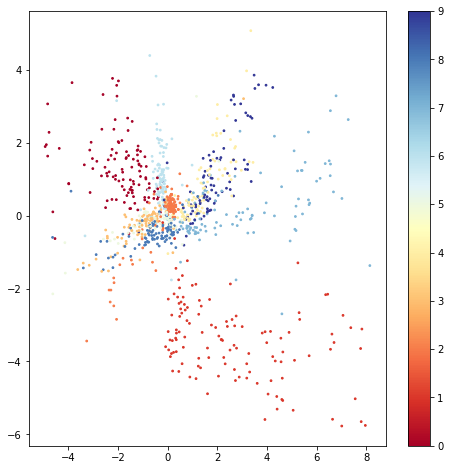

In [15]:
images, labels = next(iter(ds_test_label))
outputs = autoencoder_2.encoder.predict(images)
plt.figure(figsize=(8,8))
plt.scatter(outputs[:,0], outputs[:,1], c=labels, cmap='RdYlBu', s=3)
plt.colorbar()